<a href="https://colab.research.google.com/github/xiaoras/Optimization-with-Constraints-1/blob/master/optimization_with_constraints_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization

<p>
<div style="text-align: justify">
Most problems of data science consist in finding "optimal paramters", i.e., identifying the point $x \in \mathbb R^n$ for which some function $f$ is minimal:
\begin{align}
\text{arg}\min_x f(x)
\end{align}
Local minima (as well as local maxima and saddle points) of a multivariate function are identified by the requirement that the gradient vanishes:
\begin{align}
J_i(x) := \partial_i f(x) = 0
\end{align}
for $i=1,2,..,n$.
</div>
<p>
<ul>
  <li><div style="text-align: justify">If $f$ is convex, this requirement is sufficent to identify the global mimimum.</div></li>
  <p>
  <li><div style="text-align: justify">Otherwise, we must consider the second derivarives of $f$:
\begin{align}
H_{ij}(x) := \partial_i \partial_j f(x)
\end{align}
$H_{ij}$ can be thought of as the $(i,j)$ entry of a $n \times n$ matrix, called the Hessian $H$ of $f$. If $H(x)$ is positive-definite (i.e., its eigenvalues are all greater than zero), then $x$ is a (local) minimum. Unfortunately, the question of whether it is actually the global minimum cannot be answered easily.
      </div></li>
</ul>

### Example

<p>
<div style="text-align: justify">
Consider the following function of $x \in  \mathbb R^n$:
\begin{align}
f(x) = (\|x\|^2 - 1)^2 - 2 x_1^3 = \left(\sum_{i=1}^n x_i^2 - 1\right)^2 - 2 x_1^3
\end{align}
Let us make a contour plot of $f$ for $n = 2$.
</div>

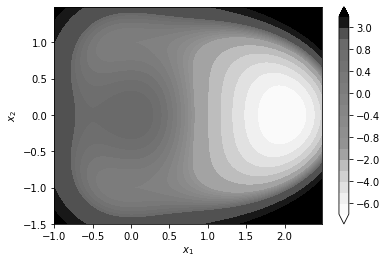

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def f(x):
    return (sum(x**2) - 1)**2 - 2 * x[0]**3

x1 = np.arange(-1.0, 2.5, 0.01)
x2 = np.arange(-1.5, 1.5, 0.01)

X1, X2 = np.meshgrid(x1, x2)
F = f(np.array([X1,X2]))

clev = [-7,-6,-5,-4,-3,-2,-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1,3,5] # contour curves
plt.contourf(X1, X2, F, clev, cmap=plt.cm.Greys, extend='both')
plt.colorbar()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

<div style="text-align: justify">
The function $f$ has global minimum for $x_1 = 2$ and all other $x_i = 0$, at which it takes value $-7$. We wish to obtain this result numerically. The following code does so using the "BFGS" method of "scipy.optimize.minimize". Note that we need to pass a point $x^{(0)}$, from which the algorithm starts the search.
</div>

In [2]:
from scipy.optimize import minimize

n = 4 # dimension of parameter space
x0 = np.ones(n) # initial point in parameter space

res = minimize(f, x0, method='BFGS')
x_min = res.x

print("x_min = {0}".format(x_min))
print("f(x_min) = {0}".format(f(x_min)))

x_min = [2.00000000e+00 1.20203119e-08 1.20203122e-08 1.20203120e-08]
f(x_min) = -7.0


<div style="text-align: justify">
An alternative method is the Newton-Conjugate-Gradient algorithm, or "Newton-CG". This method, however, requires the Jacobian "jac" of $f$, that is, the gradient vector. For our example, it is
\begin{align}
\partial_i f(x) = 4 x_i \left(\sum_{j=1}^n x_j^2 - 1\right) - \delta_{i,1} 6 x_1^2
\end{align}
The following code implements it.
</div>

In [3]:
def jac_f(x): # Jacobian of f
    n = len(x)
    d = np.zeros(n)
    d[0] = 4 * x[0] * (sum(x**2) - 1) - 6 * x[0]**2
    d[1:] = 4 * x[1:] * (sum(x**2) - 1)
    return d

n = 4
x0 = np.ones(n)

res = minimize(f, x0, method='Newton-CG', jac=jac_f)
x_min = res.x

print("x_min = {0}".format(x_min))
print("f(x_min) = {0}".format(f(x_min)))

x_min = [ 2.00000000e+00 -2.26600606e-10 -2.26600606e-10 -2.26600606e-10]
f(x_min) = -7.0


<p>
<div style="text-align: justify">
Furthermore, the method can be supplemented with the Hessian of $f$:
\begin{align}
\partial_i \partial_j f(x) = 4 \delta_{i,j} \left(\sum_{k=1}^n x_k^2 - 1\right) + 8 x_i x_j - \delta_{i,1} \delta_{j,1} 12 x_1
\end{align}
that is
\begin{align}
H(x) = 4 (\|x\|^2 - 1) I_{n} + \left(\begin{array}{ccccc}
8 x_1^2 - 12 x_1 & 8 x_1 x_2 & 8 x_1 x_3 & \cdots & 8 x_1 x_n
\\
8 x_2 x_1 & 8 x_2^2 & 8 x_2 x_3 & \cdots & 8 x_2 x_n
\\
8 x_3 x_1 & 8 x_3 x_2 & 8 x_3^2 & \cdots & 8 x_3 x_n
\\
\vdots & \vdots & \vdots & \ddots & \vdots
\\
8 x_n x_1 & 8 x_n x_2 & 8 x_n x_3 & \cdots & 8 x_n^2
\end{array}\right)
\end{align}
for $I_n$ the identity $n \times n$ matrix. The following code implements it.
</div>

In [4]:
def hess_f(x): # Hessian of f
    n = len(x)
    dd = 4 * (sum(x**2) - 1) * np.identity(n)
    for i in range(n):
        for j in range(n):
            dd[i,j] = dd[i,j] + 8 * x[i] * x[j]
    dd[0,0] = dd[0,0] - 12 * x[0]
    return dd

n = 4
x0 = np.ones(n)

res = minimize(f, x0, method='Newton-CG', jac=jac_f, hess=hess_f)
x_min = res.x

print("x_min = {0}".format(x_min))
print("f(x_min) = {0}".format(f(x_min)))

x_min = [ 2.00000000e+00 -3.03389427e-10 -3.03389427e-10 -3.03389427e-10]
f(x_min) = -7.0


# Optimization with Constraints

<p>
<div style="text-align: justify">
Sometimes, we are tasked with finding the minimum of a function $f$ subject to equality and inequality constraints in the parameter space:
\begin{align}
\text{arg}\min_{x} f(x) \ \ \ \ \ \text{subject to} \ \ c_a(x) = 0, \ \tilde c_b(x) \geq 0
\end{align}
for $a = 1,2,..,A$ and $b = 1,2,..,B$ labelling the constraints.
</div>
<p>
<div style="text-align: justify">
The theoretical framework to deal with constraints involves the method of Lagrange multipliers. For simplicity, ignore the inequality constraints: we construct the Lagrangian of the problem as
\begin{align}
L(x,\lambda) = f(x) - \sum_{a=1}^A \lambda_a c_a(x)
\end{align}
with $\lambda_a$ unknown coefficients which are added to the list of parameters, $y_I := \{x_i, \lambda_a\}$. We then compute the gradient of $L(y)$ wrt $y$:
\begin{align}
\partial_i L(y) = \partial_i f(x) - \sum_{a=1}^A \lambda_a \partial_i c_a(x), \ \ \ \ \ \partial_a L(y) = c_a(x)
\end{align}
Now, setting the gradient to zero gives $n+A$ equations for the same number of variables $x_i$ and $\lambda_a$:
\begin{align}
\partial_i f(x) = \sum_{a=1}^A \lambda_a \partial_i c_a(x), \ \ \ \ \ c_a(x) = 0
\end{align}
The second set of equations ensures that the constraints are indeed satisfied, so that we are looking for the minimum of $f$ within the hypersurface $C := \{x \in \mathbb R^n : c_a(x) = 0 \ \text{for all} \ a = 1,2,..,A\}$. As it turns out, this minimum will always be a point $x \in C$ at which the tangent space of $C$ coincides with the tangent space of $F := \{x \in \mathbb R^n : f(x) = \text{const.}\}$ (indeed, if that were not true, then there would exist a tangent vector in $T_xC$ in which direction $f$ is decreasing, and hence $x$ would not be a minimum). This property is equivalent to the statement that the gradient of $\sum_{a=1}^A \lambda_a c_a(x)$ and the grandient of $f(x)$ coincide at $x$, which is ensured by the first set of equations.
</div>
<p>
<div style="text-align: justify">
In the special case the constraints are linear and $f$ is quadratic, this is actually a set of linear equations, and can thus be solved analytically: if
\begin{align}
\partial_i f(x) = \sum_{j=1}^n D_{ij} x_j - E_i, \ \ \ \ \ c_a(x) = \sum_{j=1}^n x_j c_{ja} - k_a
\end{align}
with $E_i$ and $k_a$ constants, then the equations read
\begin{align}
\sum_{j=1}^n D_{ij} x_j - \sum_{a=1}^A c_{ia} \lambda_a = E_i, \ \ \ \ \ \sum_{j=1}^n x_j c_{ja} = k_a
\end{align}
and can thus be summarized in matrix form as
\begin{align}
M P = Q, \ \ \ \ \ \text{where} \ \ M := \left(\begin{array}{cc}
D & -c
\\
-c^T & 0
\end{array}\right), \ \ P := \left(\begin{array}{c}
x
\\
\lambda
\end{array}\right), \ \ Q := \left(\begin{array}{c}
E
\\
k
\end{array}\right)
\end{align}
The unique solution is then given by $M^{-1} Q$.
</div>
<p>
<div style="text-align: justify">
In general, however, the solution cannot be found analytically, so we must resort to numerical methods, which incidentally also take care of the inequality constraints.
</div>

### Example

<p>
<div style="text-align: justify">
Keeping $f(x)$ as in the example above, we now want to optimize it subject to the following constraints:
\begin{align}
\|x\|^2 - 1 = 0, \ \ \ \ \ -1 \leq x_i \leq 1
\end{align}
Plugging the equality constraint in $f$, it reduces to $-2 x_1^3$, which is monotonically decreasing: it is then immediate to see that the minimum in the admissible range is $x_1 = 1$ and all other $x_i = 0$, at which it is $f(x) = -2$. The following code derives this result numerically using the "Sequential Least SQuares Programming (SLSQP)" method for $n=4$.
</div>

In [5]:
# The inequalities -1 <= x_i <= 1 are actually implemented as bounds, not as inequality constraints.
bounds = [[-1,1], [-1,1], [-1,1], [-1,1]]

# Next, the constraints. In our case we have only one: c_1 = sum(x**2) - 1.
def c(x):
    return sum(x**2) - 1

def jac_c(x):
    return 2 * x

cons = [] # list of constraints: each constraint is a dictionary with 'type': 'eq' or 'ineq'
cons.append({'type' : 'eq', 'fun' : c, 'jac' : jac_c})

# Initial point in parameter space
x0 = np.array([0.1,0.1,0.1,0.1])

# Finally, we run the solver:
res = minimize(f, x0, method='SLSQP', jac=jac_f, constraints=cons, bounds=bounds)
x_min = res.x

print("x_min = {0}".format(x_min))
print("f(x_min) = {0}".format(f(x_min)))

x_min = [1.00000000e+00 3.01266671e-04 3.01266671e-04 3.01266671e-04]
f(x_min) = -1.9999999999999258


# Real Life Example: Portfolio Optimization

<p>
<div style="text-align: justify">
Consider an asset whose price is evaluated continuously in time, and denoted by $P(t)$. In general, we are interested in buying the asset at some time $t_0$ and selling it at some later time $t_1$, hoping to make some profit. The profit -- called "return" -- is of course
\begin{align}
R(t_1,\Delta t) := P(t_1) - P(t_0)
\end{align}
where $\Delta t = t_1 - t_0$ is the period of time we held onto the asset. Now, the return is a quantity with dimensions of currency, so it is not good if we want to compare it with the returns of other assets. For this reason, we divide it by the initial price $P(t_0)$, thus obatining the "rate of return" for the period $\Delta t$:
\begin{align}
r(t,\Delta t) := \dfrac{R(t,t - \Delta t)}{P(t - \Delta t)} = \dfrac{P(t)}{P(t - \Delta t)} - 1
\end{align}
The rate of return can be thought of as a percentage: it tells us how much we have earned/lost after a time period $\Delta t$, as a percentage of our initial investment. For example, suppose $r(\text{today},1 \ \text{year}) = 0.06$, that is, our investment had a yearly rate of return of $6\%$ in the year just past: this means that, if we sold today the asset that we bought one year ago for $V$ dollars, we would be making a profit of $0.06 \times V$ dollars.
</div>
<p>
<div style="text-align: justify">
How to estimate an asset's $r(t,\Delta t)$ for future $t$? First, we observe that $r(t,\Delta t)$ is derived from time series $P(t)$ by differencing: as such, it is expected to be an (approximately) stationary time series. Hence, we can imagine that historical data -- i.e., values $x_\mu := r(t_\mu,\Delta t)$ with $\mu = 1,..,m$ and $t_\mu := \mu \Delta t$ (for a total period of length $T := m \Delta t$, where $T = \text{today}$) -- are $m$ outcomes of a stochastic process $X$ with mean and variance independent of $t$. Hence, the fundamental mean $\mathbb E[X]$ and variance $\text{Var}[X] = \mathbb E[X^2] - \mathbb E[X]^2$ can be estimated by the sample mean and variance:
\begin{align}
\mathbb E[X] \approx \bar r := \dfrac{1}{m} \sum_{\mu = 1}^m x_\mu, \ \ \ \ \ \text{Var}[X] \approx \bar \sigma^2 := \dfrac{1}{m} \sum_{\mu = 1}^m x_\mu^2 - \bar r^2
\end{align}
</div>
<p>
<div style="text-align: justify">
More generally, if we have $n$ different assets, each can be associated with a stochastic process $X_{(i)}$ (with $i = 1,2,..,n$). We can then estimate the rate of return $r_i$ of $i$th asset as
\begin{align}
\mathbb E[X_{(i)}] \approx \bar r_i = \dfrac{1}{m} \sum_{\mu = 1}^m x_{\mu,i}
\end{align}
where $x_{\mu,i}$ is the historical rate of return of $i$th asset at time $t_\mu$. The covariance matrix $\text{Cov}[X_{(i)},X_{(j)}] = \mathbb E[X_{(i)}X_{(j)}] - \mathbb E[X_{(i)}] \mathbb E[X_{(j)}]$ can be estimated as
\begin{align}
\text{Cov}[X_{(i)},X_{(j)}] \approx \bar \Sigma_{ij} := \dfrac{1}{m} \sum_{\mu=1}^m x_{\mu, i} x_{\mu, j} - \bar r_i \bar r_j
\end{align}
and it is easy to see that $\bar \Sigma_{ii} = \bar \sigma_i^2$, the sample variance of the $i$th asset. Using matrix notation, we can write
\begin{align}
\mathbb E[X] \approx \bar r, \ \ \ \ \ \text{Cov}[X^T,X] \approx \bar \Sigma = \dfrac{1}{m} x^T x - \bar r^T \bar r
\end{align}
where we think of $X$ (resp., $\bar r$) as a $n$-dimensional row-vector with $i$th element $X_{(i)}$ (resp., $\bar r_i$), and of $x$ as the $m \times n$ matrix of historical data. (Note that the vector $\bar r$ is given by the mean value of each column of $x$.)
</div>
<p>
<div style="text-align: justify">
Now, a portfolio $P$ of the assets $X_{(1)},..,X_{(n)}$ consists of a linear combination
\begin{align}
P = \sum_{i=1}^n X_{(i)} w_i
\end{align}
with weights $0 \leq w_i \leq 1$ such that
\begin{align}
\sum_{i=1}^n w_i = 0
\end{align}
Collecing the weights into an $n$-dimensional column-vector $w$, we can write compactly
\begin{align}
P = X \cdot w
\end{align}
It is now easy to see that the rate of return $r_P$ and the variance $\sigma_P^2$ (also called "volatility") of the portfolio are
\begin{align}
r_P(w) = \mathbb E[P] = \mathbb E[X] \cdot w
\end{align}
and
\begin{align}
\sigma_P^2(w) = \mathbb E[P^T P] - \mathbb E[P^T] \mathbb E[P] = w^T \left(\mathbb E[X^T X] - \mathbb E[X^T] \mathbb E[X]\right) w = w^T \text{Cov}[X^T,X] w
\end{align}
They can therefore be estimated from the historical data as
\begin{align}
r_P(w) \approx \bar r \cdot w, \ \ \ \ \ \ \ \ \ \ \sigma_P^2(w) \approx w^T \bar \Sigma w = \dfrac{1}{m} w^T x^T x w - (\bar r \cdot w)^2
\end{align}
We can now use the methods described above to optimize the portfolio: for example, we can find the weights $w$ that
</div>
<p>
<ol>
  <li><div style="text-align: justify">minimize the volatility $\sigma_P^2$ while producing at least a certain rate of return, $r_P \geq r_*$</div></li>
<p>
  <li><div style="text-align: justify">maximize the rate of return $r_P$ while keeping the volatility below an acceptable threshold, $\sigma_P^2 \leq \sigma_*^2$</div></li>
<p>
  <li><div style="text-align: justify">maximize the Sharpe ratio $r_P/\sigma_P$</div></li>
</ol>
<p>
<div style="text-align: justify">
all under the constraints $0 \leq w_i \leq 1$ for all $i=1,2,..,n$ and $\sum_{i=1}^n w_i = 1$. We can also identify the **efficient frontier**, i.e., the curve $C$ in the $\sigma_P^2 - r_P$ plane of "best portfolios":
\begin{align}
C = \left\{(\sigma^2,r) \in \mathbb R^2 : r = \max_{w} r_P(w) \ \text{subject to} \ \sigma_P^2(w) = \sigma^2\right\}
\end{align}
</div>

In this example, we will import the data from Yahoo Finance using using the yfinance module (see [details](https://aroussi.com/post/python-yahoo-finance)):

In [6]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=358dcf3d36ca19d59003d3901492686fff7db232843c1186f326d1ef61e8b042
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [7]:
import yfinance as yf

ticker1, ticker2, ticker3 = "AAPL", "GOOG", "WMT"
security1 = yf.Ticker(ticker1)
security2 = yf.Ticker(ticker2)
security3 = yf.Ticker(ticker3)

df1 = security1.history(start="2012-01-03", end="2019-12-31", interval="1d")
df2 = security2.history(start="2012-01-03", end="2019-12-31", interval="1d")
df3 = security3.history(start="2012-01-03", end="2019-12-31", interval="1d")

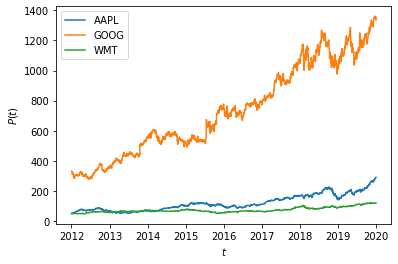

In [8]:
import pandas as pd

# Create a new dataframe "df" with the "Close" column of the three companies

df = pd.DataFrame()
df['AAPL'] = df1['Close']
df['GOOG'] = df2['Close']
df['WMT'] = df3['Close']

# Plot the three time series

plt.plot(df['AAPL'], label='AAPL')
plt.plot(df['GOOG'], label='GOOG')
plt.plot(df['WMT'], label='WMT')
plt.legend(loc='upper left')
plt.xlabel('$t$')
plt.ylabel('$P(t)$')
plt.show()

<div style="text-align: justify">
As discussed, this plot does not say much, since we are comparing different prices and the series are not stationary. To obtain (approximately) stationary series, we perform differencing by the time period $\Delta t$ of interest (in our case, $1$ day), thus obtaining the returns $R$.
</div>

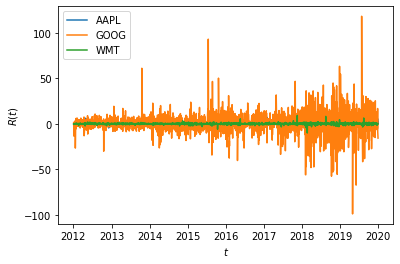

In [9]:
R = df.diff(periods=1)

plt.plot(R['AAPL'], label='AAPL')
plt.plot(R['GOOG'], label='GOOG')
plt.plot(R['WMT'], label='WMT')
plt.legend(loc='upper left')
plt.xlabel('$t$')
plt.ylabel('$R(t)$')
plt.show()

<div style="text-align: justify">
This plot still is not good for comparing different companies, since the prices of different stocks are different. We therefore divide each value by the price at the beginning of the period, thus obtaining the rate of returns $r$.
</div>

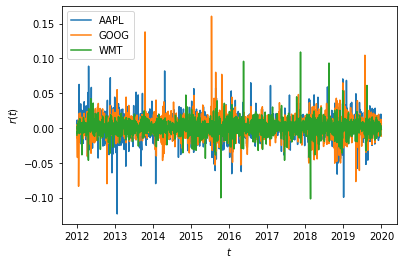

In [10]:
r = R/df.shift(periods=1)
x = r[1:] # remove the first row of r (since it consists of NaN), and call the data matrix 'x'

plt.plot(r['AAPL'], label='AAPL')
plt.plot(r['GOOG'], label='GOOG')
plt.plot(r['WMT'], label='WMT')
plt.legend(loc='upper left')
plt.xlabel('$t$')
plt.ylabel('$r(t)$')
plt.show()

<div style="text-align: justify">
Much better. To make sure, let us perform the "augmented Dickey-Fuller" test, whose null hypothesis is that the series has a unit root (meaning it is non-stationary). If the p-value is above $0.05$, then we cannot reject the null hypothesis.
</div>

In [11]:
from statsmodels.tsa.stattools import adfuller

for col in x:
    series = x[col].values
    result = adfuller(series)
    print("p-value for {0}: {1}".format(col,result[1]))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


p-value for AAPL: 1.067890792775091e-28
p-value for GOOG: 3.489488933442868e-30
p-value for WMT: 0.0


<div style="text-align: justify">
Since the p-values of all the series are extremely small, we reject th null hypothesis: the series have no unit roots, and are therefore stationary. At this point, we proceed with the construnction of the functions $\bar r$, $r_P$ and $\sigma_P^2$ (and their Jacobians) from the data matrix $r$.
</div>

In [12]:
def r_bar(X):
    return X.mean()

def rP(X,w):
    return np.dot(r_bar(X),w)

def jac_rP(X,w):
    return r_bar(X)

def sigmaP2(X,w):
    m = len(X)
    Y = np.dot(X,w)
    return (1/m) * np.dot(Y,Y) - np.dot(r_bar(X),w)**2

def jac_sigmaP2(X,w):
    m = len(X)
    XX = np.dot(np.transpose(X),X)
    return (2/m) * np.dot(XX,w) - np.dot(r_bar(X),w) * r_bar(X)

### 1. Minimizing the Volatility

<p>
<div style="text-align: justify">
We wish to minimize the volatility $\sigma_P^2$ while achieving an expected daily rate of return $r_P \geq r_*$. The optimization problem is thus
\begin{align}
\text{arg}\min_{w} f(w) \ \ \ \ \ \text{subject to} \ \ c(w) = 0, \ \tilde c(w) \geq 0
\end{align}
where $f(w) = \sigma_P^2(w)$, $c(w) = \sum_{i=1}^3 w_i - 1$, $\tilde c(w) = r_P(w) - r_*$. The following code implements it.
</div>

In [13]:
# minimum desired daily rate of return (to find yearly one, compound: (1+r_star)**n - 1, for n=253 trading days)

r_star = 0.0008

# initial guess

w0 = 0.33 * np.ones(3)

# bounds, function to be minimized and constraints

bounds = [[0,1] for i in range(len(w0))]

def f(w):
    return sigmaP2(x,w)

def jac_f(w):
    return jac_sigmaP2(x,w)

def c(w):
    return sum(w) - 1

def jac_c(w):
    return 1.0 * np.ones_like(w)

def c_tilde(w):
    return rP(x,w) - r_star

def jac_c_tilde(w):
    return jac_rP(x,w)

cons = []
cons.append({'type': 'eq', 'fun': c, 'jac': jac_c})
cons.append({'type': 'ineq', 'fun': c_tilde, 'jac': jac_c_tilde})

# Run the solver

from scipy.optimize import minimize
res = minimize(f, w0, method='SLSQP', jac=jac_f, constraints=cons, bounds=bounds)
w_min1 = res.x

print("w_min = {0}".format(w_min1))
print("sum = {0}".format(sum(w_min1)))
print("rP = {0}".format(rP(x,w_min1)))
print("sigmaP2 = {0}".format(sigmaP2(x,w_min1)))
print("Sharpe = {0}".format(rP(x,w_min1)/np.sqrt(sigmaP2(x,w_min1))))

w_min = [0.39549145 0.34239598 0.26211256]
sum = 1.0000000000000002
rP = 0.0008
sigmaP2 = 0.00011471148770853395
Sharpe = 0.07469413992328942


### 2. Maximizing the Rate of Return

<p>
<div style="text-align: justify">
We now want to maximize the rate of return $r_P$ while achieving volatility $\sigma_P^2 \leq \sigma_*^2$. The oprimization problem is
\begin{align}
\text{arg}\min_{w} f(w) \ \ \ \ \ \text{subject to} \ \ c(w) = 0, \ \tilde c(w) \geq 0
\end{align}
where $f(w) = -r_P(w)$, $c(w) = \sum_{i=1}^3 w_i - 1$, $\tilde c(w) = \sigma_*^2 - \sigma_P^2$. We implement it in the following code.
</div>

In [14]:
# maximum acceptable volatility

sigma_star2 = 0.00009

# initial guess

w0 = 0.33 * np.ones(3)

# bounds, function to be minimized and constraints

bounds = [[0,1] for i in range(len(w0))]

def f(w):
    return -rP(x,w)

def jac_f(w):
    return -jac_rP(x,w)

def c(w):
    return sum(w) - 1

def jac_c(w):
    return 1.0 * np.ones_like(w)

def c_tilde(w):
    return sigma_star2 - sigmaP2(x,w)

def jac_c_tilde(w):
    return -jac_sigmaP2(x,w)

cons = []
cons.append({'type': 'eq', 'fun': c, 'jac': jac_c})
cons.append({'type': 'ineq', 'fun': c_tilde, 'jac': jac_c_tilde})

# Run the solver

from scipy.optimize import minimize
res = minimize(f, w0, method='SLSQP', jac=jac_f, constraints=cons, bounds=bounds)
w_min2 = res.x

print("w_min = {0}".format(w_min2))
print("sum = {0}".format(sum(w_min2)))
print("rP = {0}".format(rP(x,w_min2)))
print("sigmaP2 = {0}".format(sigmaP2(x,w_min2)))
print("Sharpe = {0}".format(rP(x,w_min2)/np.sqrt(sigmaP2(x,w_min2))))

w_min = [0.21740464 0.27872241 0.50387295]
sum = 1.0
rP = 0.0006932270658565544
sigmaP2 = 9.00289248437532e-05
Sharpe = 0.07306080933314706


### 3. Maximizing the Sharpe Ratio

<p>
<div style="text-align: justify">
We want to maximize the Sharpe ratio $r_P/\sigma_P$. The problem is then casted in the form
\begin{align}
\text{arg}\min_{w} f(w) \ \ \ \ \ \text{subject to} \ \ c(w) = 0.
\end{align}
where $f(w) = -r_P/\sigma_P$, $c(w) = \sum_{i=1}^3 w_i - 1$. The code follows.
</div>

In [15]:
# initial guess

w0 = 0.33 * np.ones(3)

# bounds, function to be minimized and constraints

bounds = [[0,1] for i in range(len(w0))]

def f(w):
    return -rP(x,w)/np.sqrt(sigmaP2(x,w))

def jac_f(w):
    return jac_sigmaP2(x,w) * rP(x,w)/(2 * sigmaP2(x,w)**(3/2)) - jac_rP(x,w)/np.sqrt(sigmaP2(x,w))

def c(w):
    return sum(w) - 1

def jac_c(w):
    return 1.0 * np.ones_like(w)

cons = []
cons.append({'type': 'eq', 'fun': c, 'jac': jac_c})

# Run the solver

from scipy.optimize import minimize
res = minimize(f, w0, method='SLSQP', jac=jac_f, constraints=cons, bounds=bounds)
w_min3 = res.x

print("w_min = {0}".format(w_min3))
print("sum = {0}".format(sum(w_min3)))
print("rP = {0}".format(rP(x,w_min3)))
print("sigmaP2 = {0}".format(sigmaP2(x,w_min3)))
print("Sharpe = {0}".format(rP(x,w_min3)/np.sqrt(sigmaP2(x,w_min3))))

w_min = [0.36212291 0.27568794 0.36218916]
sum = 1.0
rP = 0.0007637226440117048
sigmaP2 = 0.00010268345168435862
Sharpe = 0.07536773051637927


### Efficient Frontier

<p>
<div style="text-align: justify">
We finally identify the efficient frontier, and check that all the points found above live on it. More precisely, we probe several values $r$ (between the minimum and maximum of $\bar r$) and, for each such value, we minimize the volatility $\sigma_P$ while setting $r_P = r$. The optimization problem is therefore
\begin{align}
\text{arg}\min_{w} f(w) \ \ \ \ \ \text{subject to} \ \ c_1(w) = 0, \ c_2(w) = 0
\end{align}
where $f(w) = \sigma_P^2(w)$, $c_1(w) = \sum_{i=1}^3 w_i - 1$, $c_2(w) = r_P - r$.
</div>

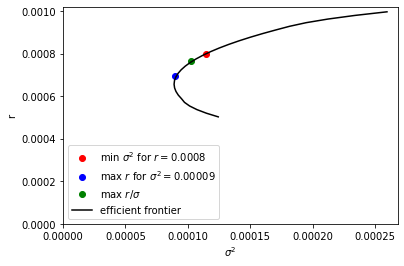

In [16]:
bounds = [[0,1] for i in range(len(w0))]

r_max = max(r_bar(r))
r_min = min(r_bar(r))
r_interval = np.linspace(r_min,r_max,num=30)

sigma2s = []
for r_star in r_interval:

    def f(w):
        return sigmaP2(x,w)

    def jac_f(w):
        return jac_sigmaP2(x,w)

    def c1(w):
        return sum(w) - 1

    def jac_c1(w):
        return 1.0 * np.ones_like(w)

    def c2(w):
        return rP(x,w) - r_star

    def jac_c2(w):
        return jac_rP(x,w)

    cons = []
    cons.append({'type': 'eq', 'fun': c1, 'jac': jac_c1})
    cons.append({'type': 'eq', 'fun': c2, 'jac': jac_c2})

    w0 = 0.33 * np.ones(3)

    from scipy.optimize import minimize
    res = minimize(f, w0, method='SLSQP', jac=jac_f, constraints=cons, bounds=bounds)

    sigma2s.append(sigmaP2(x,res.x))

plt.plot(sigmaP2(x,w_min1),rP(x,w_min1),'ro',label='min $\sigma^2$ for $r = 0.0008$')
plt.plot(sigmaP2(x,w_min2),rP(x,w_min2),'bo',label='max $r$ for $\sigma^2 = 0.00009$')
plt.plot(sigmaP2(x,w_min3),rP(x,w_min3),'go',label='max $r/\sigma$')

plt.plot(sigma2s,r_interval,'k',label='efficient frontier')
plt.xlabel("$\sigma^2$")
plt.ylabel("r")
plt.gca().set_xlim(left=0)
plt.gca().set_ylim(bottom=0)
plt.legend()
plt.show()